Install scapy conda install -c conda-forge scapy
Can generate dump data like 
sudo tcpdump -i any -s 65535 -w example.pcap

In [1]:
import numpy as np
import pandas as pd

from scapy.all import *

import pyarrow as pa
from pyarrow import csv
import liten as ten

<frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.6 of module 'liten._liten' does not match runtime version 3.8
<frozen importlib._bootstrap>:219: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 864 from C header, got 880 from PyObject


In [2]:
# rdpcap comes from scapy and loads in our pcap file
packets = rdpcap('/mnt/c/Users/hkver/Documents/dbai/pcap/example.pcap')
#packets = rdpcap('/mnt/c/Users/hkver/Documents/dbai/pcap/maccdc2012_00016.pcap')

Read packet types use commands like lsc(), pkt, type(pkt) etc.

In [3]:
packets

<example.pcap: TCP:65442 UDP:92 ICMP:0 Other:0>

In [4]:
len(packets)

65534

In [5]:
packets.conversations(type='png', target='>test.png')

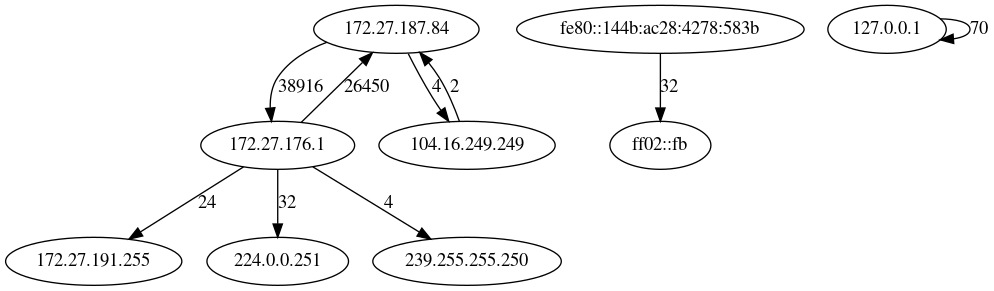

In [6]:
from IPython.display import Image
Image(filename='test.png')

Create empty pandas data frame

In [7]:
ip_schema = pa.schema((pa.field('src_ip',pa.string()),
                       pa.field('dst_ip',pa.string()),
                       pa.field('flags',pa.uint8()),
                       pa.field('length',pa.uint32())
))
record_batches = []

Iterate through all the packets and populate the dataframe

In [8]:
batch_size = 1000
src_ip = []
dst_ip = []
flags = np.ndarray(shape=(batch_size),dtype='uint8')
lengths = np.ndarray(shape=(batch_size),dtype='uint32')
ip_pkts = 0
tcp_pkts = 0
none_pkts = 0
batch_num = 0
pkt_num = 0
for pkt in packets:
    if IP in pkt:
        ip_pkts = ip_pkts + 1
        flags[pkt_num] = pkt[IP].flags
        lengths[pkt_num] = pkt[IP].len
        src_ip.append(pkt[IP].src)
        dst_ip.append(pkt[IP].dst)
        pkt_num = pkt_num + 1
    elif TCP in pkt:
        tcp_pkts = tcp_pkts + 1
    else:
        none_pkts = none_pkts + 1

    if (batch_size == pkt_num):
        record_batches.append(
            pa.record_batch(data=[src_ip, dst_ip, flags, lengths],schema=ip_schema)
        )
        pkt_num = 0
        batch_num - batch_num+1
        src_ip.clear()
        dst_ip.clear()

print(f'IP={ip_pkts} TCP={tcp_pkts} None={none_pkts}')

IP=65502 TCP=0 None=32


TCP New Conn
Hosts for which the number of newly opened TCP connections exceeds threshold.
SELECT dstIp, count(*) FROM ipv4packet
WHERE tcp_flags == 2
GROUPBY dstIp
RANGE BETWEEN INTERVAL ‘1’ HOUR PRECEDING AND CURRENT ROW

In [9]:
new_connections = { }
for record_batch in record_batches:
    for row_num in range(0, record_batch.num_rows):
        if record_batch.column(2)[row_num].as_py() == 2:
            dst_ip = record_batch.column(1)[row_num].as_py()
            if dst_ip in new_connections:
                new_connections[dst_ip] = new_connections[dst_ip] + 1
            else:
                new_connections[dst_ip] = 1
print(new_connections)


{'172.27.176.1': 38663, '172.27.187.84': 26211, '172.27.191.255': 24, '224.0.0.251': 32, '127.0.0.1': 62, '104.16.249.249': 4, '239.255.255.250': 4}
